# NLP Assignment 3
Created by Prof. [Mohammad M. Ghassemi](https://ghassemi.xyz)

Submitted by: <span style="color:red"> INSERT YOUR NAME HERE </span>

In collaboration with: <span style="color:red"> INSERT YOUR (OPTIONAL) HOMEWORK PARTNER'S NAME HERE </span>


<hr> 

In [21]:
import importlib
from materials.code import utils
importlib.reload(utils)

# IMPORT SOME BASIC TOOLS:
from pprint import pprint
import pyarrow
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

[nltk_data] Downloading package punkt to /Users/ghamut/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<hr>

# Part 2: Model Optimization


#### Tuning Paramters with Grid Search
In the previous sections we saw that our choice of features and `hyper-parameters` had a big impact on the model's optimization of its `paramters`, and consequently, it's performance on the training and test sets! But up until now, we've taken it for granted that the model will always just figure out the optimal value of the paramters on its own, given some example data, and a notion of $loss$ that we provide it. Let's spend some time exploring how models actually determine the values of the paramters. 

To begin, let's assume that we have some data $x$ (e.g. the number of '!' characters in some text), that we want to use to generate $y$ (a binary indicator that the text is happy or not). Let's plot the data to start:



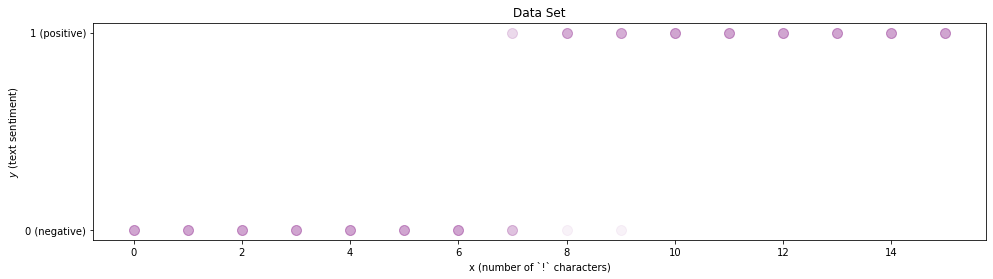

In [22]:
#------------------------------------------------------
# Open the Data File
#------------------------------------------------------
with open('./materials/performance/dummydata.json') as f:
    data = json.load(f)
x,y = data['x'], data['y']

#------------------------------------------------------
# Plot the Data
#------------------------------------------------------
def plot_data():
    plt.plot(x,y, '.', markersize=20, color='purple', alpha=0.05)
    plt.title('Data Set')
    plt.xlabel('x (number of `!` characters)')
    plt.ylabel('$y$ (text sentiment)')
    plt.yticks(ticks = [0,1], labels = ['0 (negative)','1 (positive)'])

    
plt.figure(figsize=(16,4))
plot_data()
plt.show()

<br><br>Because this is binary data, a lot of points overlap; the opacity of the points in the above plot is proportional to the number of overlapping data points. At a glance, it looks like a sigmoid might be a good way to model the relationship beween $x$ and $y$:

$$\hat{y} = \frac{1}{1 + e^{-(mx + b)}} $$

Where $\hat{y}$ refers to the predictions generated by our model, so as to distinguish them from the actual values from the data, $y$. The exact shape of the sigmoid that estimates $\hat{y}$ from $x$, is controlled by two model paramers: $m$, and $b$. Let's write a simple function that generates a sigmoid, and plot it for a given value of m and b

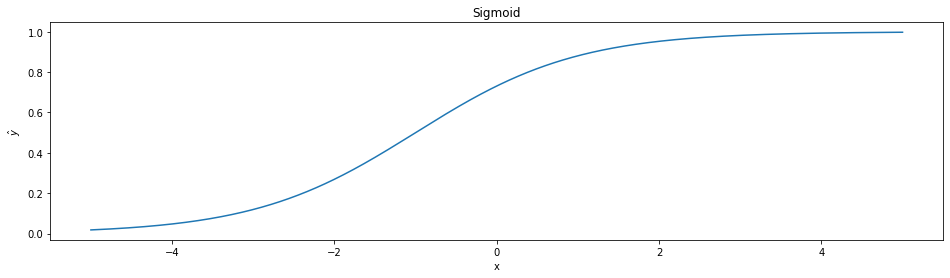

In [23]:
import math

#------------------------------------------------------
# A sigmoid function
#------------------------------------------------------
def sigmoid(m,b,x):
    return 1/(1 + math.exp(-(m*x + b)))

#------------------------------------------------------
# Function to plot a sigmoid
#------------------------------------------------------
def plot_sigmoid(m,b, xran = [-5,5], bold=False):
    x     = list(np.linspace(xran[0],xran[1],1000))
    y_hat = [sigmoid(m=m,b=b,x=x_i) for x_i in x]
    
    if bold == False:
        plt.plot(x,y_hat, label='Logistic regression (m =' + str(m) + ', b =' + str(b) + ')')
    else:
        plt.plot(x,y_hat, linewidth=4, label='Logistic regression (m =' + str(m) + ', b =' + str(b) + ')')
    plt.title('Sigmoid')
    plt.xlabel('x')
    plt.ylabel('$\hat{y}$')

    
    
#------------------------------------------------------
# Plot the sigmpid for m = 1 and b =1
#------------------------------------------------------
plt.figure(figsize=(16,4))
plot_sigmoid(1,1)

<br><br>That looks like a sigmoid! Let's overlay this random sigmoid on top of our data to see how well it fits the data.



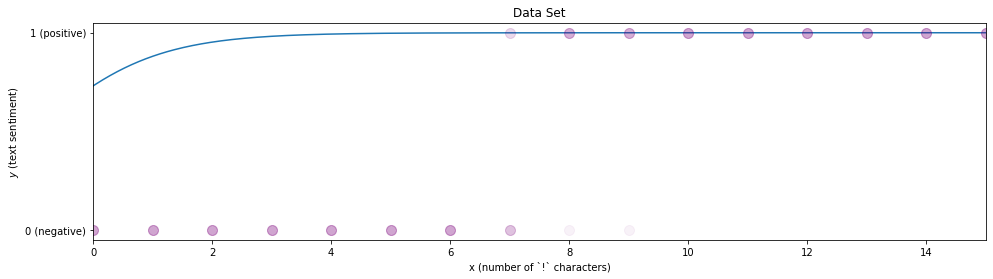

In [24]:
plt.figure(figsize=(16,4))
plot_sigmoid(1,1,[-15,15])
plot_data()
plt.xlim([0,15])
plt.show()

<br><br>We can tell with just our eyes that this model (with its current paramters) is not a good fit. Our model, (the blue line) is (basically) always predicting that the sentiment is high. Let's try some different values of the $b$ parameter to see if we can find a better fit.

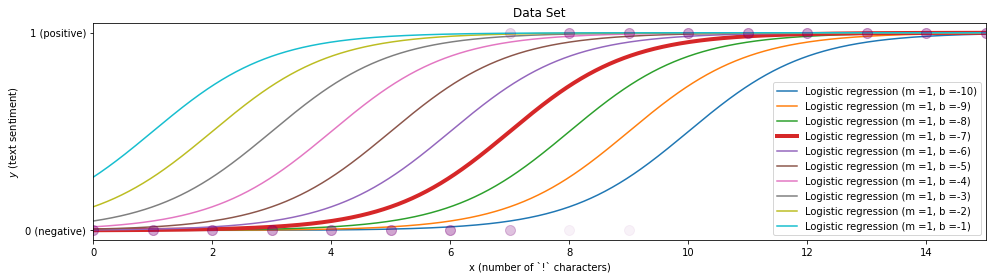

In [25]:
# Plot the Data and the Model for various values of b.
plt.figure(figsize=(16,4))
for b in range(-10,0):
    if b == -7:
        plot_sigmoid(1,b,[0,15], bold=True) 
    else:
        plot_sigmoid(1,b,[0,15]) 
plt.legend()
plot_data()
plt.xlim([0,15])
plt.show()

<br><br> Just using our eyes, it *seems* that the bold red line (corresponding to when $b=-7$) provides the best fit; we still have one more paramter that we can tune, so let's hold $b$ at -7 and tune $m$ next.  

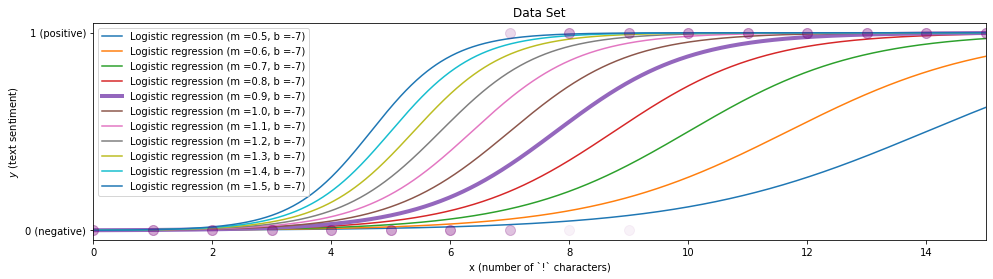

In [26]:
# Plot the Data and the Model for various values of b.
plt.figure(figsize=(16,4))
for m in np.linspace(0.5,1.5,11):
    m = np.round(m,2)
    if m == 0.9:
        plot_sigmoid(m,-7,[0,15], bold=True) 
    else:
        plot_sigmoid(m,-7,[0,15]) 
plt.legend()
plot_data()
plt.xlim([0,15])
plt.show()

<br><br> it looks like $m=0.9$ might be a slightly better fit than $m=1$; Let's plot model with these new parameters over the data.

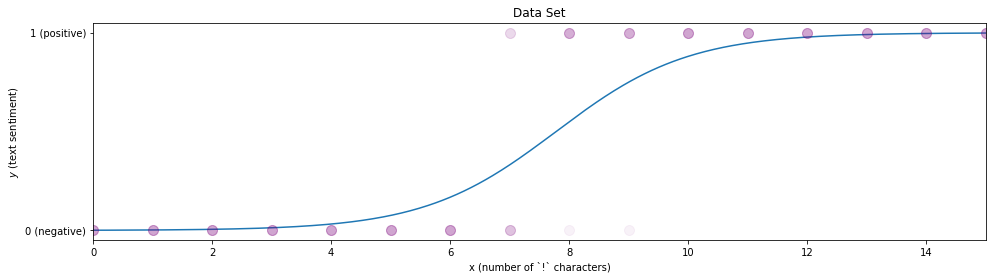

In [27]:
plt.figure(figsize=(16,4))
plot_sigmoid(0.9,-7,[-15,15])
plot_data()

plt.xlim([0,15])
plt.show()

That looks pretty good, intuitively - but is it the **best** fit? In order to know that for sure, we need a way a formally compare the fit of the model that is more rigourous than just using our eyeballs; this is exactly what a loss function is for. The loss function provides a way to measure the $p(data|model)$ (or the $p(model|data)$ if you're feeling Bayesian) with respect to the value of the model parameters. In the case of the logistic regression model, the cost function is referred to as Cross Entropy.


$$Cross Entropy = -y \log(\hat{y}) - (1 - y) \log(1-\hat{y}) $$

Or in software form:

In [28]:
#------------------------------------------------------
# Cross Entropy Cost Function
#------------------------------------------------------
def CrossEntropy(yHat, y):
    if y == 1:
      return -math.log(yHat)
    else:
      return -math.log(1 - yHat)

<br><br>Notice that the Cross Entropy function computes the loss for a given pair of $y$ and $\hat{y}$. Hence, we can compute the total cost of the model by summing (or averaging) the costs associated with each of the data points:

In [29]:
# A function to compute the loss given the paramters (m and b), and the data (x and y).
def compute_loss(m,b,x,y):
    y_hat = [sigmoid( m = m, b = b, x = x_i) for x_i in x]
    costs = [CrossEntropy(y_hat[i], y[i])    for i   in range(len(y))]
    return sum(costs)


<br><br>Let's sanity check this by comparing the costs for the two settings of the paramters we were looking at earlier:

In [30]:
# Import the data
x,y   = data['x'], data['y']
#------------------------------------------------------
# Compute the Total Costs for m=0.9 and b = -7
#------------------------------------------------------
print('----------------------------------------')
print('Loss when m=0.9 and b = -7         ')
print('----------------------------------------')
cost = compute_loss(m=0.9,b=-7,x=x,y=y)
print(np.round(cost,2))

#------------------------------------------------------
# Compute the Total Costs for m=1 and b = 1
#------------------------------------------------------
print('\n----------------------------------------')
print('Loss when m = 1 and b = 1          ')
print('----------------------------------------')
cost = compute_loss(m=1,b=1,x=x,y=y)
print(np.round(cost,2))

----------------------------------------
Loss when m=0.9 and b = -7         
----------------------------------------
17.99

----------------------------------------
Loss when m = 1 and b = 1          
----------------------------------------
287.14


<br><br> Based on the visual inspection from earlier, it seems like our loss function makes sense. Remember, because this is a $loss$ function - the bigger the number, the worse the fit! With a loss function in place, we can more thoroughly explore the relationship between the paramters and the cost function using a `grid search`:

In [31]:
#-------------------------------------------------
# Explore the relationship between m,b, and costs
#------------------------------------------------
costs, min_loss =  [], np.Inf

# For several values of m
for m in np.linspace(-3,3,50):
    cost_row = []
    
    # ... and several values of b
    for b in np.linspace(-9,9,50):
        
        # compute the loss and store it
        loss = compute_loss(m=m,b=b,x=x,y=y)
        cost_row.append(loss)
        
        # if this is the lowest loss, save it.
        if loss < min_loss:
            best_m, best_b = m, b
            min_loss = loss
            
    costs.append(cost_row)

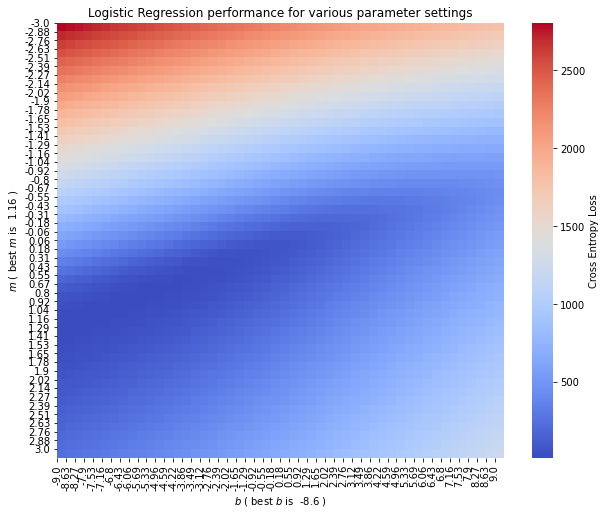

In [32]:
#-------------------------------------------------------
#Generate a heatmap
#-------------------------------------------------------
plt.figure(figsize = (10,8))
ax = sns.heatmap(costs, cmap='coolwarm', cbar_kws={'label': 'Cross Entropy Loss'})

#-------------------------------------------------------
# Set the X Label and Tickmarks:
#-------------------------------------------------------
plt.xlabel("$b$" + " ( best $b$ is  " + str(best_b)[0:4] + " )")
plt.xticks(ticks   = range(0,50), labels   = [round(x,2) for x in np.linspace(-9,9,50)], rotation = 'vertical')

#-------------------------------------------------------
# Set the Y Labels and Tickmarks:
#-------------------------------------------------------
plt.ylabel("$m$" + " ( best $m$ is  " + str(best_m)[0:4] + " )")
plt.yticks(ticks    = range(0,50), labels   = [round(x,2) for x in np.linspace(-3,3,50)], rotation = 'horizontal')

plt.title("Logistic Regression performance for various parameter settings")
plt.show()

<br><br>The above chart implies that the best parameter pair is actually when $b=-8.6$, and $m=1.16$. It looks like our visual inspection ($m=0.9$ and $b = -7$) was close, but unsurprisingly, having a formal definition of loss helped us find the values of $m$ and $b$ more effectively than just glacing at this with our eyes; alas - we are only human. But wait! In the previous section we had applied regularization to our model - let's update the loss function here to see how that changes the results: 

In [33]:
# A function to compute the loss given the paramters (m and b), and the data (x and y).
def compute_loss_reg(m,b,x,y):
    y_hat = [sigmoid( m = m, b = b, x = x_i) for x_i in x]
    costs = [CrossEntropy(y_hat[i], y[i])    for i   in range(len(y))]
    
    # UPDATED TO ADD L2 REGULARIZATION!
    regularized_costs = costs + pow(b,2) + pow(m,2)
    
    return sum(regularized_costs)

In [34]:
#-------------------------------------------------
# Explore the relationship between m,b, and costs
#------------------------------------------------
costs_reg, min_loss =  [], np.Inf

# For several values of m
for m in np.linspace(-3,3,50):
    cost_row = []
    
    # ... and several values of b
    for b in np.linspace(-9,9,50):
        
        # compute the loss and store it
        loss = compute_loss_reg(m=m,b=b,x=x,y=y)
        cost_row.append(loss)
        
        # if this is the lowest loss, save it.
        if loss < min_loss:
            best_m, best_b = m, b
            min_loss = loss
            
    costs_reg.append(cost_row)

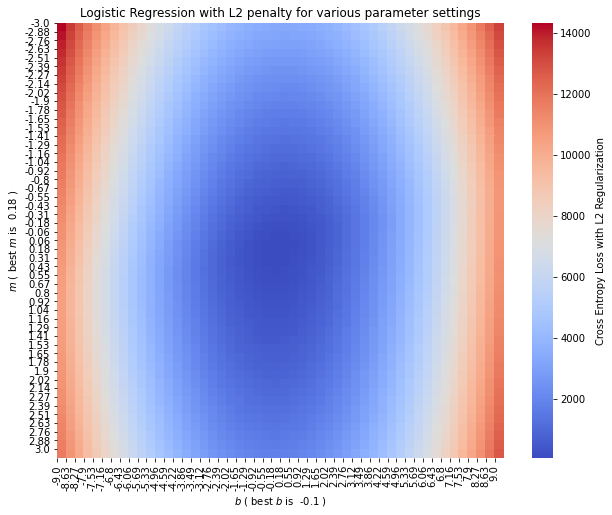

In [35]:
#-------------------------------------------------------
#Generate a heatmap
#-------------------------------------------------------
plt.figure(figsize = (10,8))
ax = sns.heatmap(costs_reg, cmap='coolwarm', cbar_kws={'label': 'Cross Entropy Loss with L2 Regularization'})
plt.xlabel("$b$" + " ( best $b$ is  " + str(best_b)[0:4] + " )")
plt.xticks(ticks   = range(0,50), labels   = [round(x,2) for x in np.linspace(-9,9,50)],rotation = 'vertical')
plt.ylabel("$m$" + " ( best $m$ is  " + str(best_m)[0:4] + " )")
plt.yticks(ticks    = range(0,50), labels   = [round(x,2) for x in np.linspace(-3,3,50)],rotation = 'horizontal')
plt.title("Logistic Regression with L2 penalty for various parameter settings")
plt.show()

<br><br> With this modification to the loss function, we see that the new choice of the optimal parameters has changed; unsurpringly, they are much smaller than the values we saw without the regularization because the loss function adds more penalty for larger individual coefficient values! 

#### The Limitations of grid search:
In the previous section we wrote our very own logistic regression model and optimized the paramters of our model by defining a notion of loss, and identifying the setting of the paramters that minimized that loss; that is, we basically tried out many pairs of $m$ and $b$ until we found a pair of values that worked the best, and kept those.

This approach of searching over the paramter grid to find the optimal values is referred to as `grid search`; it works well when we have only a few paramters we want to optimize, but what happens as we increase the number of paramters we need to optimize? In the previous section, we needed two nested `for` loops, one for each of the paramters in our model. Hence, if we had three paramters, we would have needed three nested `for` loops, four paramters would require four `for` loops and so on. We can express this relationship between the size of the grid search space for $n$ features with an equation:

$$ s = \prod_{i=1}^{n}r_i$$

Where $s$ represents the number of grid points we would need to search, $n$ is in the number of paramters, and $r_i$ denotes the resolution of our grid search for feature $i$. This means that for a constant value of $r_i \neq 1$, the search space grows exponentially with the number of features! For instance, to perform a grid search for the 18,330 features in our bag-of-words model at the tiny resolution of $r_i=2$ would require us to search $2^{18,330}$ possible parameter settings - that's more than the estimated number of particles in the observable universe. Here's that number, for your viewing pleasure: 

In [36]:
print('------------------------------------------------------------')
print('Number of paramters settings to explore:')
print('------------------------------------------------------------')
print(pow(2,18330))

------------------------------------------------------------
Number of paramters settings to explore:
------------------------------------------------------------
758264145336405306878637894486192194534192842651993820927003093751627845117742525418143926718068976956693872325955619007145700459591141206269181228638213349579302265619908312686547273177334952358349306410553861996917505508008949049468713995845673030452770137583950650819276771304905282199848235149611118373422131075516383445896001401017975042577316391472113850854756745124932827644602973683827653949294810073962898265679032382083692740419620245377711783239615156176274319369244176110492118205179501111517117416398328901994673699441467978752573611695378759799907532049413382705701402710149920517532842746831148714438125476059427786208232533300363047693846846617774026010241986724900607235296237020887136904294680585239075229027096354424756000809752924572458776914884433160499263445493218298212022217818854175700101831479156345894481894877

<br><br> 

#### Gradient Descent

Clearly we will need a better way to solve for the optimal paramter values of the model than grid search. You may recall from earlier that there was a smooth **convex gradient** on the Cross Entropy Loss surface when we were optimizing $m$ and $b$ with the grid search. That is, the loss grew **consistently** higher as we moved further away from the optimal values of $m$ and $b$. If we had a way to measure this gradient at a given location, then we wouldn't have to explore the whole grid to arrive at the the optimal point. Instead, we could: 

1. Start at a random point 
2. Check the gradient (i.e slope) at that point
3. If the gradient is 0 - we're done, else take a small step in the negative direction of the gradient 
4. Go back to step 2... 

We would perform this process for several steps until the gradient was 0 (or something very close to it), at which point we would know we've reached the botom of the Loss surface. This process is what is referred to as **gradient descent** in machine learning.

So how do we get the gradient of the loss? That's what derivatives are for! Recall from your introduction to calculus class that the derivative of a function provides the slope (i.e. the gradient) of that function at any point. So, if we wanted to know the gradient of the loss, we'll need to take it's derivative with respect to the paramters. 

$$\frac{\partial loss }{\partial m} =$$

$$\frac{\partial(-y \log(\hat{y}) - (1 - y) \log(1-\hat{y}) )}{\partial m} =$$ 

$$\frac{\partial( -y \log(\hat{y}))}{\partial m} + \frac{\partial(-(1 - y) \log(1-\hat{y}) )}{\partial m} $$

<br>
and now substituting the sigmoid equation in for $\hat{y}$, and taking the derivate we obtain:
<br><br>

$$\frac{\partial( -y \log(\frac{1}{1 + e^{-(mx + b)}} ))}{\partial m} + \frac{\partial(-(1 - y) \log(1-\frac{1}{1 + e^{-(mx + b)}} ) )}{\partial m} $$

$$   y[-x \frac{1}{1 + e^{mx + b}}] + (1-y)[x\frac{e^{mx + b}}{1 + e^{mx + b}}]  $$

<br>
We can restructure the terms a bit so we can redefine things in terms of $\hat{y}$ again (just because it's easier to read!):
<br><br>

$$   y[-x (1 - \frac{1}{1 + e^{-(mx + b)}})] + (1-y)[x \frac{1}{1 + e^{-(mx + b)}}]  $$

$$   y[-x(1 - \hat{y})] + (1-y)[x\hat{y}]  $$

$$   y[x(\hat{y} - 1)] + (1-y)[x\hat{y}]  $$

<br>
Hence, the change in the loss with respect to $m$ is described by:
<br>

$$\frac{\partial loss }{\partial m} = y[x(\hat{y} - 1)] + (1-y)[x\hat{y}] $$

<br>
and similarly for $b$:
<br>

$$\frac{\partial loss }{\partial b} = y[\hat{y} - 1] + (1-y)[\hat{y}] $$


Now that we've derived the gradient in the loss function with respect to the coefficients, let's write these equations, and all the other supporting functions down together as code so we can actually use them for an end-to-end gradient descent powered logistic regression!


In [37]:
#------------------------------------------------------
# Fucntion to Compute the gradient in loss wrt m and b
#------------------------------------------------------
def compute_gradient(y,yhat,x):
    
    # gradient in m for all the data
    dl_dm = [y[i] *( x[i] * (yhat[i] - 1)) + (1 - y[i]) * (x[i] * yhat[i]) for i in range(len(y))] 
    
    # gradient in b for all the data
    dl_db = [y[i] *((yhat[i] - 1)) + (1 - y[i]) * yhat[i] for i in range(len(y))]   
    
    # return the sum of the gradients across all the data points
    return sum(dl_dm), sum(dl_db)


#------------------------------------------------------
# Cross Entropy Cost Function
#------------------------------------------------------
def CrossEntropy(yHat, y):
    if y == 1:
      return -math.log(yHat)
    else:
      return -math.log(1 - yHat)

#------------------------------------------------------
# Compute the Total Loss
#------------------------------------------------------
def compute_loss(m,b,x,y):
    y_hat = [sigmoid( m = m, b = b, x = x_i) for x_i in x]
    costs = [CrossEntropy(y_hat[i], y[i])    for i   in range(len(y))]
    return sum(costs)

#------------------------------------------------------
# A sigmoid function
#------------------------------------------------------
def sigmoid(m,b,x):
    return 1/(1 + math.exp(-(m*x + b)))

<br><br> Now lets test out of gradient descent optimization of the paramter values for the same problem we solved using the grid search earlier and save the values of $b$ and $m$ that we traverse in the course of the optimization:

In [38]:
#------------------------------------------------------
# Applying our Gradient Descent Optimizer
#------------------------------------------------------
# Initialize some data
x,y = data['x'], data['y']

# Initialize the paramters
m,b = 1,1 

# Initialize a learning rate
learning_rate = 0.005
epochs    = 3000

# save the values of b and m we traverse:
bs,ms = [], []

for count in range(epochs):
    # Compute the loss and print it.
    
    # Generate the predictions
    yhat = [sigmoid(m,b,x[i]) for i in range(len(x))]
    
    # Compute the gradients:
    dl_dm, dl_db = compute_gradient(y,yhat,x)
    
    # Take a step in the direction of the gradient.
    if dl_dm > 0:
        m-= learning_rate
    else:
        m+= learning_rate

    if dl_db > 0:
        b-= learning_rate
    else:
        b+= learning_rate
    bs.append(b)
    ms.append(m)


<br><br> The `learning_rate` in the above code describes the size of the step we will take in the direction of the gradient and the `epochs` indicates how many steps we will take before returning the parameters. Let's plot values of $m$ and $b$ over the 3000 epochs (iterations) of the algorithm:

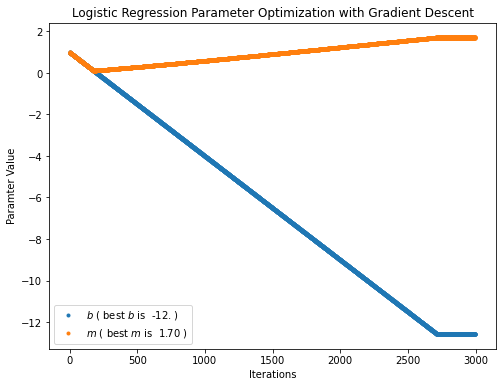

In [39]:
plt.figure(figsize = (8,6))
plt.plot(bs,'.', label="$b$" + " ( best $b$ is  " + str(bs[-1])[0:4] + " )")
plt.plot(ms,'.', label="$m$" + " ( best $m$ is  " + str(ms[-1])[0:4] + " )")
plt.xlabel("Iterations")
plt.ylabel("Paramter Value")
plt.title("Logistic Regression Parameter Optimization with Gradient Descent")
plt.legend()
plt.show()

<br><br> We can see clearly from the figure above that our gradient descent algorithm converged. It seems to have arrived at a value of -12 for $b$ and 1.70 for $m$. Let's compare the total loss that was computed by gradient descent to the value we arrived at by grid search:

In [40]:
#------------------------------------------------------
# The loss of the paramters from gradient descent
#------------------------------------------------------    
print('-----------------------------------------------')
print('Total Loss using Gradient Descent paramters')
print('-----------------------------------------------')
loss = compute_loss(m=m,b=b,x=x,y=y)
print(loss)

#------------------------------------------------------
# The Loss from Grid search
#------------------------------------------------------ 
print('\n-----------------------------------------------')
print('Total Loss using Grid search paramters')
print('-----------------------------------------------')
loss = compute_loss(m=1.16,b=-8.6,x=x,y=y)
print(loss)


-----------------------------------------------
Total Loss using Gradient Descent paramters
-----------------------------------------------
13.007785327271762

-----------------------------------------------
Total Loss using Grid search paramters
-----------------------------------------------
14.950966356748976


<br><br> It seems that gradient descent is not only more computationally scalable with the number of features, but it even arrived at a better answer.


<hr> 

## Learning Exercise 2: 
#### Worth 2/5 Points
#### A. Change Learning Rate
Using the same simple dataset and implementaion of logistic regression from this tutorial, explore several values of the `learning_rate`, and `iterations` in the implementation provided in the tutorial and comment on the convergence of the algorithm for the settings you explore.

In [41]:
################################################################################
# INSERT YOUR CODE HERE
# DO NOT FORGET TO DISCUSS YOUR RESULTS
################################################################################

<span style="color:red"> INSERT AN INTERPRETATION OF YOUR RESULTS HERE </span>

#### B. General Purpose Logistic Regression
One problem with our implementation of the logistic regression model above is that it only performs optimizarion of two parameters $m$ and $b$. For this exercise, you will create a new logistic regression function that operates more closely to the basic `sklearn` implementation of logistic regression (i.e. without regualrization). That is, your code should take an input dataset $X$ with $n$ columns, and an binary output target $y$; your code should should determines the optimal values of $n+1$ coefficients for that dataset using gradient descent.

In [42]:
################################################################################
# INSERT YOUR CODE HERE
# DO NOT FORGET TO DISCUSS YOUR RESULTS
################################################################################

<span style="color:red"> INSERT AN INTERPRETATION OF YOUR RESULTS HERE </span>

#### C. Compare your implementation to Sklearn
Use your implementaiton from Part B. to classify the Rotton Tomatoes Movie review dataset after transforming the bag-of-words representation using PCA and retaining the first 10 principal components. Compare the performance of your logistic regression model and the parameter values against the `sklearn` Logistic Regression. Are the coefficients and performance the same? Why, or why not?  

In [43]:
################################################################################
# INSERT YOUR CODE HERE
# DO NOT FORGET TO DISCUSS YOUR RESULTS
################################################################################

<span style="color:red"> INSERT AN INTERPRETATION OF YOUR RESULTS HERE </span>

<h1><span style="color:red"> Self Assessment </span></h1>
Please provide an ssessment of how successfully you accomplished the learning exercises in this assignment according to the instruction provided; do not assign youself points for effort. This self assessment will be used as a starting point when I grade your assignments. Please note that if you over-estimate your grade on a given learning exercise, you will face a 50% penalty on the total points granted for that exercise. If you underestimate your grade, there will be no penalty.

* Learning Exercise: 
    * <span style="color:red">X</span>/2 points